In [4]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import plot_distribution
from qiskit_experiments.library import LocalReadoutError, CorrelatedReadoutError
from qiskit.result.mitigation.utils import expval_with_stddev, str2diag, counts_probability_vector
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakePerth

from qiskit_ibm_provider import IBMProvider
from qiskit_ibm_provider.job import job_monitor

In [158]:
# Run only once to save the account
#IBMProvider.save_account(token='27fc81cc1143099c58b23780dbcb4725f2393a6016b59258fece524e61c35934cfac5f04ca7d1253750225e775c3cc1df4fd115bd23f4632961569d497648186')

In [167]:
provider = IBMProvider()
provider.active_account()

qpu = provider.get_backend()


QiskitBackendNotFoundError: 'More than one backend matches the criteria'

In [5]:
# Define a backend
backend = AerSimulator.from_backend(FakePerth())

MITIGATION EXPERIMENT

In [6]:
# Define # of shots for mitigation and qubits
miti_shots = 8192
qubits = [0]
num_qubits = len(qubits)

In [59]:
# Set up the mitigation experiment
exp = LocalReadoutError(qubits)

# Print mitigation experiment circuits
for c in exp.circuits():
    print(c)

         ░ ┌─┐
     q: ─░─┤M├
         ░ └╥┘
meas: 1/════╩═
            0 
        ┌───┐ ░ ┌─┐
     q: ┤ X ├─░─┤M├
        └───┘ ░ └╥┘
meas: 1/═════════╩═
                 0 


In [61]:
# Runs the mitigation experiment and retrieves the results
exp.analysis.set_options(plot=True)
result = exp.run(backend, shots=miti_shots)
mitigator = result.analysis_results("Local Readout Mitigator").value

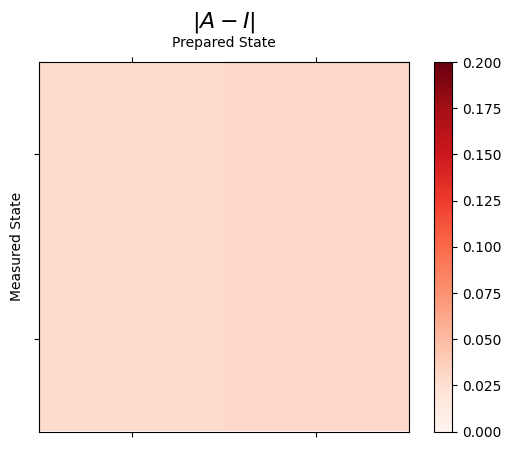

In [62]:
# Graph the confusion matrix
result.figure(0)

In [63]:
# Print the confusion matrix
for m in mitigator._mitigation_mats:
    print(m)

[[ 1.02974926 -0.03272418]
 [-0.02974926  1.03272418]]


ACTUAL EXPERIMENT

In [64]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit import Parameter
from qiskit.result import marginal_counts

In [65]:
# Define constants & parameters
pi = np.pi
phi_R = Parameter('phi_R') 
phi_S = Parameter('phi_S')

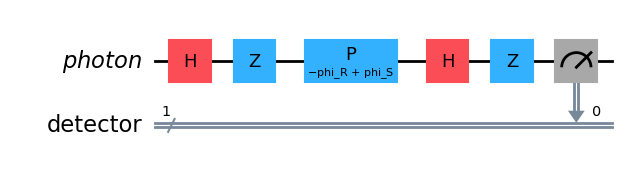

In [66]:
# Create a quantum register named "photon" and a classical bit
qr_photon = QuantumRegister(1, 'photon')
cr = ClassicalRegister(1, 'detector')

# Create a circuit with 1 qubit and 1 classical bit
qc = QuantumCircuit(qr_photon, cr)

# 1st BS; creates a superposition and a phase shift by π
qc.h(0)
qc.z(0)

# Phase shift by total of 2π due to the mirrors
# qc.p(pi*2,0)

# Phase shifts by (φ_S - φ_R) due to the lengths
qc.p(phi_S-phi_R,0)

# 2nd BS and a phase shift by π
qc.h(0)
qc.z(0)

# Measurement on qubit 0 (photon), projection on cbit 0 (detector)
qc.measure(0,0)

# Draw the circuit
qc.draw('mpl')

In [67]:
# ASSIGN PARAMS HERE
param_values = {phi_S: pi, phi_R: pi}
bound_qc = qc.assign_parameters(param_values)

# Transpile the circuit
qc_trans = transpile(bound_qc, backend)

# Run the experiment for 2^13 shots
shots = 8192
job = backend.run(qc_trans, shots=shots, memory=True)

POST PROCESSING

Unmitigated Counts: 
{'0': 238, '1': 7954}
mitigated quasi probs:  {0: -0.00185642331598, 1: 1.00185642331598}
mitigated probs:  {0: -0.00185642331598, 1: 1.00185642331598}
Mitigated Counts: 
{'1': 8192.0}


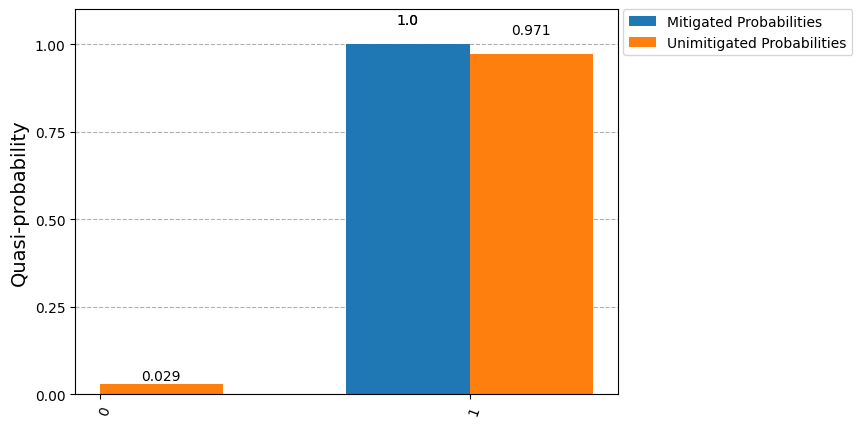

In [68]:
# Get counts before mitigation
result = job.result()
counts = result.get_counts()

# Print unmitigated counts
print("Unmitigated Counts: ")
print(counts)

# Get unmitigated probabilities = (counts/total # of shots) for each state
unmitimitigated_probs = {label: count/shots for (label, count) in counts.items()}


# Get quasi-probabilites (can include negative or greater than 1)
mitigated_quasi_probs = mitigator.quasi_probabilities(counts)
print('mitigated quasi probs: ', mitigated_quasi_probs)

# Convert quasi-probabilities to the nearest probability distribution by L2 norm
mitigated_probs = mitigated_quasi_probs.nearest_probability_distribution().binary_probabilities()
print('mitigated probs: ', mitigated_quasi_probs)

# Get mitigated counts 
# GET COUNTS BY INVERSION CONFUSION MATRIX 
mitigated_counts = {label: prob*shots for (label, prob) in mitigated_probs.items()}


# Print mitigated counts
print("Mitigated Counts: ")
print(mitigated_counts)

# Plot mitigated & unmitigated probabilities
legend = ['Mitigated Probabilities','Unimitigated Probabilities']
plot_distribution([mitigated_probs, unmitimitigated_probs], legend=legend)